In [159]:
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow import keras

from functions.image import get_satellite_raw_uint8

In [160]:
dataset = rasterio.open("./data/crs.tiff")
img_data = dataset.read(1)
block_size = 30

In [161]:
import glob

examples = glob.glob("./examples/*/*.png", recursive=True)

In [162]:
import imageio

kernel1 = np.ones((5, 5), np.float32) / 25

X = []
Y = []
for path in examples:
    category = path.split("/")[2]
    img = imageio.imread(path)
    if category == "land" or category == "beach":
        img = np.expand_dims(img / 255.0, -1)
        X.append(img)
        Y.append(0)
    elif category == "ocean" or category == "boat" or category == "windmill":
        img = np.expand_dims(img / 255.0, -1)
        X.append(img)
        Y.append(1)

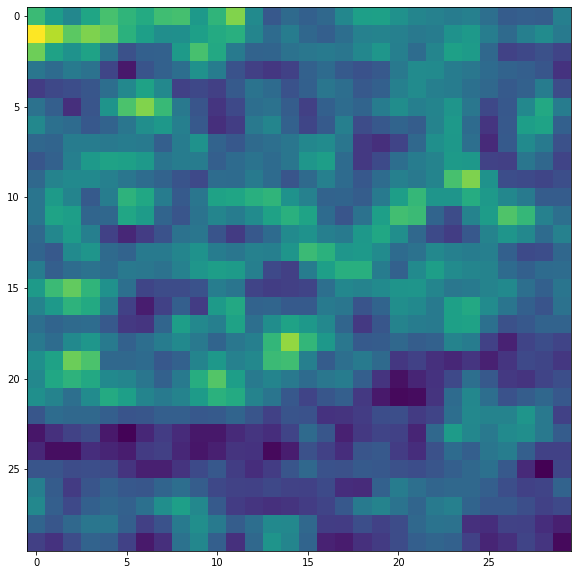

In [163]:
from matplotlib import pyplot as plt

im_land = X[0]
plt.imshow(im_land)

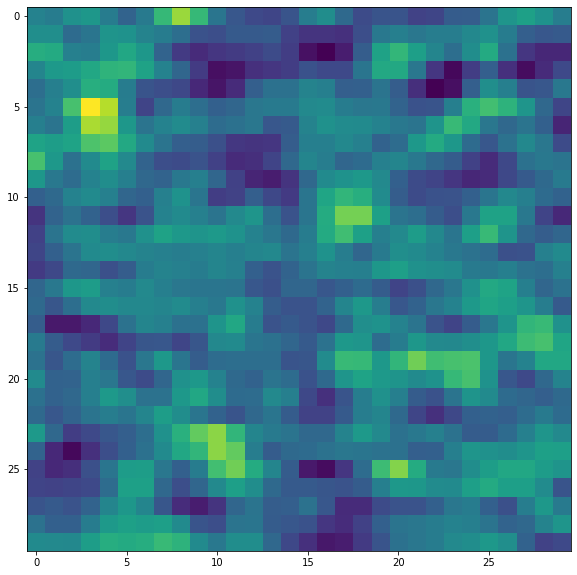

In [164]:
im_ocean = X[len(X) - 1]
plt.imshow(im_ocean)

In [165]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

X_train = np.stack(X_train)
X_test = np.stack(X_test)
Y_train = keras.utils.to_categorical(Y_train, 2)
Y_test = keras.utils.to_categorical(Y_test, 2)

In [166]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

model.add(Conv2D(6, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=20)

Epoch 1/20
41/41 [==============================] - 1s 6ms/step - loss: 0.5726 - accuracy: 0.7019
Epoch 2/20
41/41 [==============================] - 0s 6ms/step - loss: 0.4599 - accuracy: 0.8261

In [167]:
model.evaluate(X_test, Y_test, verbose=2)

5/5 - 0s - loss: 0.2625 - accuracy: 0.8472 - 122ms/epoch - 24ms/step


[0.2625364065170288, 0.8472222089767456]

303/1617 is ocean


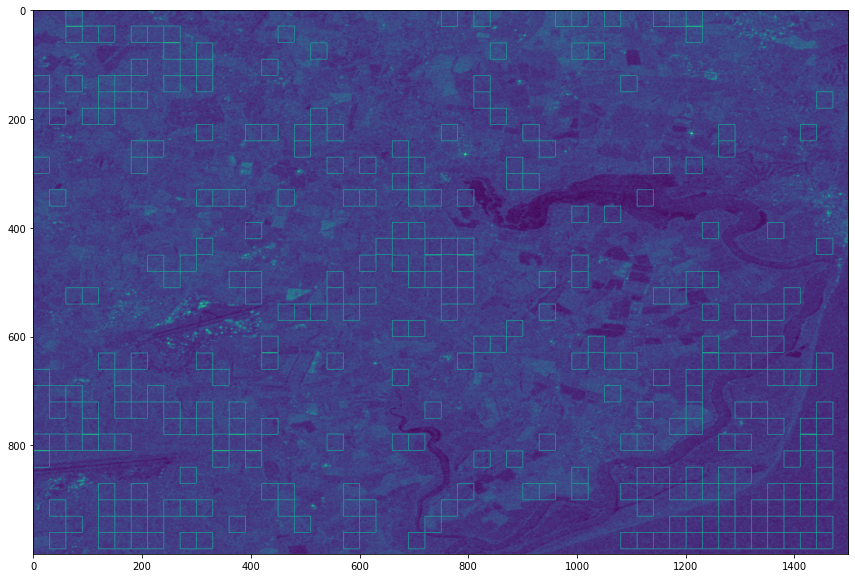

In [170]:
left_top_coord = (1.39111,52.20703)  # enter coordinate here
img_h, img_w = (750*2, 500*2)
left_top_x, left_top_y = dataset.index(left_top_coord[0], left_top_coord[1])
needles = []
step_size = 30

for xx in range(left_top_x + block_size // 2, left_top_x + img_w - block_size // 2, step_size):
    for yy in range(left_top_y + block_size // 2, left_top_y + img_h - block_size // 2, step_size):
        cc = dataset.transform * (yy, xx)
        needles.append({'lon': cc[0], 'lat': cc[1]})

test_data = np.stack(
    [np.expand_dims(get_satellite_raw_uint8(coord, block_size, img_data, dataset) / 255.0, -1) for coord in needles])
results = model.predict(test_data)

from matplotlib import pyplot as plt

search_space = np.copy(img_data[left_top_x:left_top_x + img_w, left_top_y:left_top_y + img_h])
search_space = search_space ** (1 / 4)
highlight = np.max(search_space) * 0.75

found = 0
for i, result in enumerate(results):
    if result[1] > result[0]:
        found += 1
        coord = needles[i]
        xx, yy = dataset.index(coord['lon'], coord['lat'])
        xx -= left_top_x
        yy -= left_top_y

        search_space[xx - block_size // 2:xx + block_size // 2, yy - block_size // 2] = highlight
        search_space[xx - block_size // 2:xx + block_size // 2, yy + block_size // 2] = highlight
        search_space[xx - block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight
        search_space[xx + block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight

print("{}/{} is ocean".format(found, len(needles)))

plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(search_space)

In [122]:
results[0]

array([0.8136283 , 0.11797854], dtype=float32)